In [3]:
#script 4  Second order hunger
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import toeplitz, cholesky, sqrtm, inv
import math as m

# Define time settings
T = 80
dt = 0.005
t = np.arange(0, T, dt)
N  = t.size

F = np.zeros(N)
x = np.zeros(N)
x_dot = np.zeros(N)
ya = np.zeros(N)
ya_dot = np.zeros(N)
yb = np.zeros(N)
yb_dot = np.zeros(N)
mu = np.zeros(N)
phi = np.zeros(N)
phi_2 = np.zeros(N)
mu_x = np.zeros(N)
mu_x_dot = np.zeros(N)
u = np.zeros(N)
mu_v = np.zeros(N)
mu_v_dot = np.zeros(N)
x_int = np.zeros(N)

# precisions
#sensor 1
omega_az0 = np.ones(N)*5
omega_az1 = np.ones(N)*5

#sensor 2
omega_bz0 = np.ones(N)*5
omega_bz1 = np.ones(N)*5


# internal precisions
omega = np.ones(N)*10
omega_2 = np.ones(N)*10
omega_3= np.ones(N)*5
omega_4 = np.ones(N)*5
#learning rates
alpha = 1       
alpha_u = 1



#initiazation
mu[0] =28
mu_x[0] = 28
x[0]= 28
x_hung = 28


for i in np.arange(0,N-1):
    #generative process of external position
    x_dot[i] = u[i]
    x[i+1] = x[i] + dt*x_dot[i]
  
    if i == 0.4*N: 
        x[i+1] = x[i]
        
    #generative process of internal states     
    x_int = x[i]

    x_hung_dot = 28- x[i]
    x_hung = x_hung+ dt*x_hung_dot

 

    #sensory states
    ya[i] = x[i]
    ya_dot[i] = x_dot[i]
    yb[i] = x[i] 
    yb_dot[i] = x_dot[i]


    if i >0.15*N:
        ya[i] = x[i]#+2
        yb[i] = x[i] 


    if i > 0.3*N:
        ya[i] = x[i]#+2
        yb[i] = x[i] #+ np.random.randn(1)*1



    # set precisioon matrices for iteration
    PIa_z = np.diag([omega_az0[i],1])
    PIb_z = np.diag([omega_bz0[i],1])
    PI_w = np.diag([1,1])

   
    #internal temperature estimation
    phi[i] = x_int# + np.random.rand(1)*0.1
    eps_1 = phi[i] - mu[i] 
    mu_prior = 30
    eps_2 = mu[i] - mu_prior


    #hunger estimation
    phi_2[i] = x_hung
    eps_3  = phi_2[i] - mu[i]
    hunger_prior = 28
    eps_4 = mu[i] - hunger_prior

    
    #external prediction errors
    e_x = np.array([[mu_x_dot[i]], [0]]) - (np.array([[-mu_x[i]],[-mu_x_dot[i]]]) + np.array([[mu[i]],[0]]))
    e_ya = np.array([[ya[i]],[ya_dot[i]]]) - np.array([[mu_x[i]],[mu_x_dot[i]]])
    e_yb = np.array([[yb[i]],[yb_dot[i]]]) - np.array([[mu_x[i]],[mu_x_dot[i]]])

    
    #external depth estimation update
    dFdmu_x = np.array([[1,1],[0,1]]).T.dot(np.dot(PI_w,e_x)) - np.dot(np.identity(2),np.dot(PIa_z,e_ya)) - np.dot(np.identity(2),np.dot(PIb_z,e_yb)) 
    dmu_x = np.array([[mu_x_dot[i]], [0]]) - alpha*dFdmu_x
    mu_x[i+1] = mu_x[i] + dt*dmu_x[0]
    mu_x_dot[i+1] = mu_x_dot[i] +dt*dmu_x[1]



    #Free Energy MOET NOG WORDEN VERBETERD!!!!!!!!
    F[i] =0.5*(e_x.T.dot(PI_w.dot(e_x)) + e_ya.T.dot(PIa_z).dot(e_ya) +  e_yb.T.dot(PIb_z).dot(e_yb) + eps_1*omega[i]*eps_1 + eps_2*omega_2[i]*eps_2 - np.log(np.linalg.det(PI_w)) - np.log(np.linalg.det(PIa_z)) - np.log(np.linalg.det(PIb_z)))

    #causal state update
    # dFdmu = np.array([[-1,0],[0,0]]).T.dot(np.dot(PI_w,e_x)) + np.array([[omega_2[i],0]])*np.array([[eps_2],[0]]) - np.array([[omega[i]],[0]])*np.array([[eps_1],[0]]) + np.array([[omega_4[i],0]])*np.array([[eps_4],[0]]) - np.array([[omega_3[i]],[0]])*np.array([[eps_3],[0]])
    dFdmu = np.array([[-1,0],[0,0]]).T.dot(np.dot(PI_w,e_x)) + np.array([[omega_2[i]*eps_2],[0]] ) - np.array([[omega[i]*eps_1],[0]] )+ np.array([[omega_4[i]*eps_4],[0]])- np.array([[omega_3[i]*eps_3],[0]] )

    dmu = -alpha*dFdmu
    mu[i+1] = mu[i] + dt*dmu[0]


    #Action updating
    u_dot = -np.array([0,1]).dot(PIa_z).dot(e_ya) -np.array([0,1]).dot(PIb_z).dot(e_yb) 
    u[i+1] = u[i] + alpha_u*dt*u_dot
    

    
    # precision updating
    # dPI_w = alpha_w*0.5*(inv(PI_w) - np.diag(e_x.flatten())**2)
    # PI_w = PI_w + dt*dPI_w

    alpha_1 = 0.1
    alpha_2 = 0.1
    alpha_3 = 0.1
    alpha_4 = 0.1
    alpha_za = 0.1
    alpha_zb = 0.1

    domega = alpha_1*0.5*(1/omega[i] - eps_1**2)
    domega_2 = alpha_2*0.5*(1/omega_2[i]- eps_2**2)
    omega[i+1] = omega[i] + dt*domega
    omega_2[i+1] = omega_2[i] + dt*domega_2

    
    domega_3 = alpha_3*0.5*(1/omega_3[i] - eps_3**2)
    domega_4 = alpha_4*0.5*(1/omega_4[i]- eps_4**2)
    omega_3[i+1] = omega_3[i] + dt*domega_3
    omega_4[i+1] = omega_4[i] + dt*domega_4


    dPIa_z = alpha_za*0.5*(inv(PIa_z) - np.diag(e_ya.flatten())**2)
    PIa_z = PIa_z + dt*dPIa_z
    omega_az0[i+1] = PIa_z[0,0]
    omega_az1[i+1] = PIa_z[1,1]

    dPIb_z = alpha_zb*0.5*(inv(PIb_z) - np.diag(e_yb.flatten())**2)
    PIb_z = PIb_z + dt*dPIb_z
    omega_bz0[i+1] = PIb_z[0,0]
    omega_bz1[i+1] = PIb_z[1,1]


    #just so the graph wont show zero at the end
    # phi[i+1] = x[i+1]
    



C:\Users\SIDTUDelft\AppData\Local\Temp\ipykernel_8044\2305674781.py:127: RuntimeWarning: invalid value encountered in log
  F[i] =0.5*(e_x.T.dot(PI_w.dot(e_x)) + e_ya.T.dot(PIa_z).dot(e_ya) +  e_yb.T.dot(PIb_z).dot(e_yb) + eps_1*omega[i]*eps_1 + eps_2*omega_2[i]*eps_2 - np.log(np.linalg.det(PI_w)) - np.log(np.linalg.det(PIa_z)) - np.log(np.linalg.det(PIb_z)))
C:\Users\SIDTUDelft\AppData\Local\Temp\ipykernel_8044\2305674781.py:127: RuntimeWarning: overflow encountered in scalar multiply
  F[i] =0.5*(e_x.T.dot(PI_w.dot(e_x)) + e_ya.T.dot(PIa_z).dot(e_ya) +  e_yb.T.dot(PIb_z).dot(e_yb) + eps_1*omega[i]*eps_1 + eps_2*omega_2[i]*eps_2 - np.log(np.linalg.det(PI_w)) - np.log(np.linalg.det(PIa_z)) - np.log(np.linalg.det(PIb_z)))
C:\Users\SIDTUDelft\AppData\Local\Temp\ipykernel_8044\2305674781.py:127: RuntimeWarning: invalid value encountered in add
  F[i] =0.5*(e_x.T.dot(PI_w.dot(e_x)) + e_ya.T.dot(PIa_z).dot(e_ya) +  e_yb.T.dot(PIb_z).dot(e_yb) + eps_1*omega[i]*eps_1 + eps_2*omega_2[i]*eps_2 

ValueError: array must not contain infs or NaNs

In [4]:
#script 4  First order hunger
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import toeplitz, cholesky, sqrtm, inv
import math as m

# Define time settings
T =150
dt = 0.005
t = np.arange(0, T, dt)
N  = t.size

F = np.zeros(N)
x = np.zeros(N)
x_dot = np.zeros(N)
ya = np.zeros(N)
ya_dot = np.zeros(N)
yb = np.zeros(N)
yb_dot = np.zeros(N)
mu = np.zeros(N)
phi = np.zeros(N)
phi_2 = np.zeros(N)
mu_x = np.zeros(N)
mu_x_dot = np.zeros(N)
u = np.zeros(N)
mu_v = np.zeros(N)
mu_v_dot = np.zeros(N)
x_int = np.zeros(N)

# precisions
#sensor 1
omega_az0 = np.ones(N)*5
omega_az1 = np.ones(N)*5

#sensor 2
omega_bz0 = np.ones(N)*5
omega_bz1 = np.ones(N)*5


# internal precisions
omega = np.ones(N)*5
omega_2 = np.ones(N)*5
omega_3= np.ones(N)*5
omega_4 = np.ones(N)*5
#learning rates
alpha = 1       
alpha_u = 1



#initiazation
mu[0] = 29
mu_x[0] = 29
x[0]= 29


for i in np.arange(0,N-1):
    #generative process of external position
    x_dot[i] = u[i]
    x[i+1] = x[i] + dt*x_dot[i]
  
    if i == 0.4*N: 
        x[i+1] = x[i]
        
    #generative process of internal states     
    x_int = x[i+1]
    x_hung = x[i+1]


    #sensory states
    ya[i] = x[i]
    ya_dot[i] = x_dot[i]
    yb[i] = x[i] 
    yb_dot[i] = x_dot[i]


    if i >0.15*N:
        ya[i] = x[i]#+2
        yb[i] = x[i] 


    if i > 0.3*N:
        ya[i] = x[i] #+2
        yb[i] = x[i] + np.random.randn(1)*1



    # set precisioon matrices for iteration
    PIa_z = np.diag([omega_az0[i],0.1*omega_az0[i]])
    PIb_z = np.diag([omega_bz0[i],0.1*omega_bz0[i]])
    PI_w = np.diag([1,1])

   
    #internal temperature estimation
    phi[i] = x_int# + np.random.rand(1)*0.1
    eps_1 = phi[i] - mu[i] 
    mu_prior = 30
    eps_2 = mu[i] - mu_prior


    #hunger estimation
    phi_2[i] = x_int
    eps_3  = phi_2[i] - mu[i]
    hunger_prior = 28
    eps_4 = mu[i] - hunger_prior

    
    #external prediction errors
    e_x = np.array([[mu_x_dot[i]], [0]]) - (np.array([[-mu_x[i]],[-mu_x_dot[i]]]) + np.array([[mu[i]],[0]]))
    e_ya = np.array([[ya[i]],[ya_dot[i]]]) - np.array([[mu_x[i]],[mu_x_dot[i]]])
    e_yb = np.array([[yb[i]],[yb_dot[i]]]) - np.array([[mu_x[i]],[mu_x_dot[i]]])

    
    #external depth estimation update
    dFdmu_x = np.array([[1,1],[0,1]]).T.dot(np.dot(PI_w,e_x)) - np.dot(np.identity(2),np.dot(PIa_z,e_ya)) - np.dot(np.identity(2),np.dot(PIb_z,e_yb)) 
    dmu_x = np.array([[mu_x_dot[i]], [0]]) - alpha*dFdmu_x
    mu_x[i+1] = mu_x[i] + dt*dmu_x[0]
    mu_x_dot[i+1] = mu_x_dot[i] +dt*dmu_x[1]



    #Free Energy MOET NOG WORDEN VERBETERD!!!!!!!!
    F[i] =0.5*(e_x.T.dot(PI_w.dot(e_x)) + e_ya.T.dot(PIa_z).dot(e_ya) +  e_yb.T.dot(PIb_z).dot(e_yb) + eps_1*omega[i]*eps_1 + eps_2*omega_2[i]*eps_2 - np.log(np.linalg.det(PI_w)) - np.log(np.linalg.det(PIa_z)) - np.log(np.linalg.det(PIb_z)))

    #causal state update
    # dFdmu = np.array([[-1,0],[0,0]]).T.dot(np.dot(PI_w,e_x)) + np.array([[omega_2[i],0]])*np.array([[eps_2],[0]]) - np.array([[omega[i]],[0]])*np.array([[eps_1],[0]]) + np.array([[omega_4[i],0]])*np.array([[eps_4],[0]]) - np.array([[omega_3[i]],[0]])*np.array([[eps_3],[0]])
    dFdmu = np.array([[-1,0],[0,0]]).T.dot(np.dot(PI_w,e_x)) + np.array([[omega_2[0]*eps_2],[0]] ) - np.array([[omega[0]*eps_1],[0]] )+ np.array([[omega_4[0]*eps_4],[0]])- np.array([[omega_3[0]*eps_3],[0]] )
    dmu = -alpha*dFdmu[0]
    mu[i+1] = mu[i] + dt*dmu[0]


    #Action updating
    u_dot = -np.array([0,1]).dot(PIa_z).dot(e_ya) -np.array([0,1]).dot(PIb_z).dot(e_yb) 
    u[i+1] = u[i] + alpha_u*dt*u_dot
    

    
    # precision updating
    # dPI_w = alpha_w*0.5*(inv(PI_w) - np.diag(e_x.flatten())**2)
    # PI_w = PI_w + dt*dPI_w

    alpha_1 = 1
    alpha_2 = 1
    alpha_3 = 1
    alpha_4 = 1
    alpha_za = 1
    alpha_zb = 1

    domega = alpha_1*0.5*(1/omega[i] - eps_1**2)
    domega_2 = alpha_2*0.5*(1/omega_2[i]- eps_2**2)
    omega[i+1] = omega[i] + dt*domega
    omega_2[i+1] = omega_2[i] + dt*domega_2

    
    domega_3 = alpha_3*0.5*(1/omega_3[i] - eps_3**2)# HIER NOG NAAR KIJKEN
    domega_4 = alpha_4*0.5*(1/omega_4[i]- eps_4**2) 
    omega_3[i+1] = omega_3[i] + dt*domega_3
    omega_4[i+1] = omega_4[i] + dt*domega_4

    dPIa_z = alpha_za*0.5*(inv(PIa_z) - np.diag(e_ya.flatten())**2)
    PIa_z = PIa_z + dt*dPIa_z
    omega_az0[i+1] = PIa_z[0,0]
    omega_az1[i+1] = PIa_z[1,1]

    dPIb_z = alpha_zb*0.5*(inv(PIb_z) - np.diag(e_yb.flatten())**2)
    PIb_z = PIb_z + dt*dPIb_z
    omega_bz0[i+1] = PIb_z[0,0]
    omega_bz1[i+1] = PIb_z[1,1]


    #just so the graph wont show zero at the end
    phi[i+1] = x[i+1]
    


In [ ]:
print(np.array([[omega_2[0],0]]).dot(np.array([[eps_2],[0]]) ))
print(np.array([[omega_2[0],0]])*np.array([[eps_2],[0]]) )

print(np.array([[-1,0],[0,0]]).T.dot(np.dot(PI_w,e_x)) )
print(np.array([[-1,0],[0,0]]).T.dot(np.dot(PI_w,e_x)) + np.array([[omega_2[0]*eps_2],[0]] ))


# print(np.array([[-1,0],[0,0]]).T.dot(np.dot(PI_w,e_x)))

# print(np.array([[-1,0],[0,0]]).T.dot(np.dot(PI_w,e_x)) + np.array([[omega_2[i],0]])*np.array([[eps_2],[0]]) - np.array([[omega[i]],[0]])*np.array([[eps_1],[0]]) + np.array([[omega_4[i],0]])*np.array([[eps_4],[0]]) - np.array([[omega_3[i]],[0]])*np.array([[eps_3],[0]]))

[[-6.22817098]]
[[-6.22817098 -0.        ]
 [ 0.          0.        ]]
[[-0.03729056]
 [ 0.        ]]
[[-6.26546153]
 [ 0.        ]]


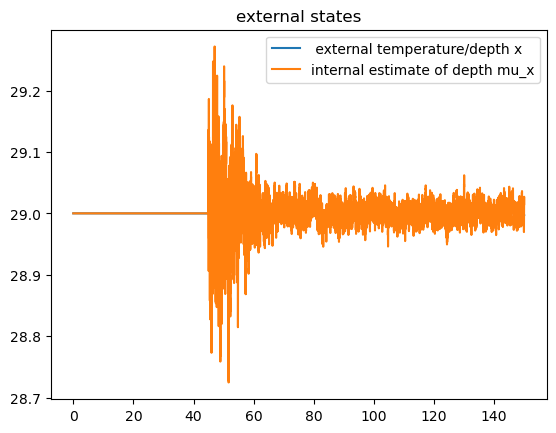

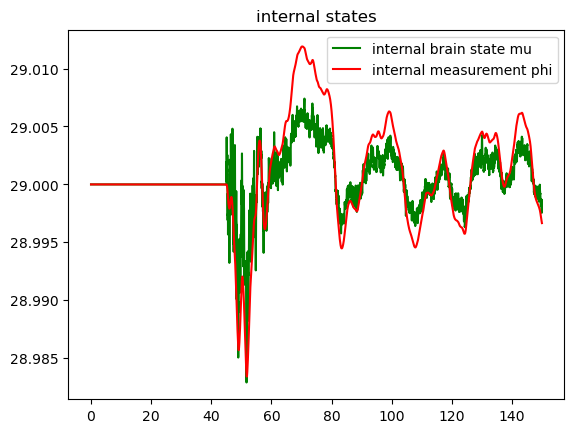

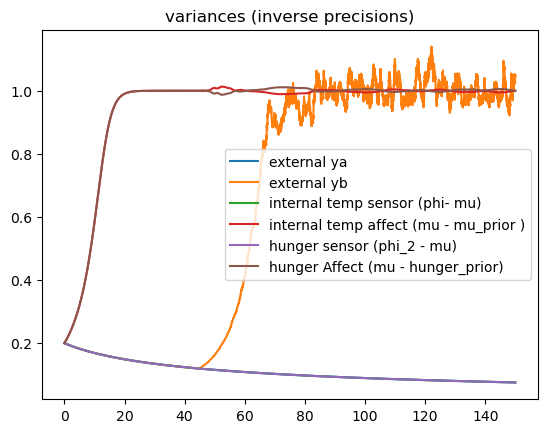

In [5]:
#plot 3

plt.figure()
plt.plot(t, x, label = " external temperature/depth x")
plt.plot(t,mu_x, label = "internal estimate of depth mu_x")
plt.title("external states")
plt.legend()

plt.figure()
plt.plot(t, mu, label = "internal brain state mu" , color = "g")
plt.plot(t, phi, label = "internal measurement phi", color = "r")
plt.title("internal states")
plt.legend()
# plt.plot(mu_dot)

plt.figure()
plt.plot(t,1/omega_az0, label =  "external ya")
plt.plot(t,1/omega_bz0, label = "external yb")
plt.plot(t, 1/omega, label = "internal temp sensor (phi- mu)")
plt.plot(t, 1/omega_2, label = "internal temp affect (mu - mu_prior )")
plt.plot(t, 1/omega_3, label = "hunger sensor (phi_2 - mu)")
plt.plot(t, 1/omega_4, label = "hunger Affect (mu - hunger_prior)")
plt.title("variances (inverse precisions)")

plt.legend()

